In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

### Make a single time series, nonlinear in time (periodic), noisy

In [2]:
t = np.linspace(0, 10, 2000)
x = np.sin(t) + np.sin(2*t) + np.sin(3*t) + np.random.normal(0, 0.1, len(t))

### Lift into a high dimensional space (time delay embedding)

In [7]:
X = scipy.linalg.hankel(x)[0:200,0:-200] # just the first 200 delays

In [8]:
Xm = X[:, 0:-1]
Xp = X[:, 1:]

### Take SVD

In [9]:
U,E,Vt = np.linalg.svd(Xm)

E is returned as a row vector, not super useful. Make it an appropriately shaped square. 

In [10]:
if Vt.shape[0] > U.shape[1]:
    E = np.hstack((E, np.zeros(Vt.shape[0] - U.shape[1])))
    Ed = np.diag(E)
    Ed = Ed[0:U.shape[1], :]

### Rank truncate SVD

In [11]:
r = 5
Ur = U[:, 0:r]
Er = Ed[0:r, 0:r]
Vtr = Vt[0:r, :]

### Project X into SVD space

In [46]:
Xmr = Ur.T@Xm
Xpr = Ur.T@Xp

### Build Ar (Atilde)

In [47]:
Ar = Ur.T@Xp@Vtr.T@np.linalg.inv(Er)

### Run KF in SVD space

Note: since we have measurements of all the states, this is really just going to reduce the noise.

In [48]:
import requests 

url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [49]:
# make zero valued controls and B matrix to work with KF

Br = np.atleast_2d(np.zeros([Ar.shape[0]])).T
u = np.zeros_like(Xm)[0:1,:]

In [50]:
# measurements are all the states

Cr = np.eye(Ar.shape[0])

In [57]:
R = 0.1**2*np.eye(Ar.shape[0])
Q = 1e-4*np.eye(Ar.shape[0])

In [58]:
x0r = np.atleast_2d(Xmr[:,0]).T
P0r = np.eye(Ar.shape[0])

In [59]:
Yr = Xpr

In [60]:
xhat_fp_r, xhat_fm_r, P_fp_r, P_fm_r = __kalman_forward_filter__(x0r, P0r, Yr, u, Ar, Br, Cr, R, Q)

In [61]:
xhat_fp_r.shape

(5, 1799)

### Reproject into original basis

In [62]:
xhat_fp = Ur@xhat_fp_r

In [63]:
xhat_fp.shape

(200, 1799)

### The real x that we're after is the first row of what should be a hankel matrix

In [64]:
xhat = xhat_fp[0,:]

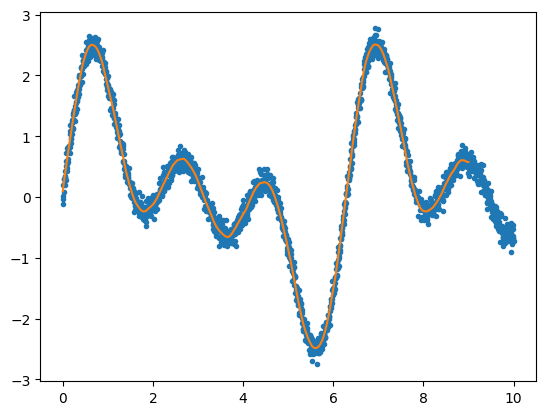

In [67]:
plt.plot(t, x, '.')
plt.plot(t[0:len(xhat)], xhat)